In [2]:
import os
import random
import numpy as np
import pandas as pd

from PIL import Image
import unicodedata
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tqdm.auto import tqdm

from helpers import slugify



In [3]:

# Configuration
ARTEMIS_PATH = "data/artemis-v2/dataset/combined/train/artemis_preprocessed.csv"
WIKIART_ROOT = "data/wikiart_extracted"

# Subset configuration
USE_SUBSET = False        # Set to True to use a subset, False to use all train/val data
SUBSET_FRACTION = 0.05     # Fraction of the combined train+val data to use (e.g., 0.1 for 10%)

# Training configuration
BATCH_SIZE = 32
NUM_WORKERS = 4
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
RANDOM_SEED = 6552
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualization configuration
SAVE_FIGS = False
CURRENT_TIME = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED) 

df = pd.read_csv(ARTEMIS_PATH)
print(f"Loaded {len(df)} annotations.")

df['image_file'] = df['image_file'].apply(lambda x: unicodedata.normalize('NFC', x))
df.head()

Loaded 475996 annotations.


,emotion,utterance,art_style,painting,repetition,version,split,emotion_label,image_file,grounding_emotion
0,sadness,This painting shows a gloomy day. The darkness...,Realism,johan-hendrik-weissenbruch_windy-day,1,new,train,7,data/wikiart_extracted/Realism/johan-hendrik-w...,sadness
1,sadness,the weather and atmosphere makes me feel sad,Romanticism,ivan-aivazovsky_landscape-with-a-schooner-1880,45,new,train,7,data/wikiart_extracted/Romanticism/ivan-aivazo...,sadness
2,sadness,"Dark and moody, cloudy sky that is depressing",Impressionism,paul-gauguin_clearing-1873,18,new,train,7,data/wikiart_extracted/Impressionism/paul-gaug...,sadness
3,sadness,the picture is dark with a somber tone,Impressionism,john-henry-twachtman_winter-landscape,7,new,val,7,data/wikiart_extracted/Impressionism/john-henr...,sadness
4,sadness,the dark colors make the painting look gloomy,Impressionism,eugene-boudin_trouville-the-port-1864,5,new,test,7,data/wikiart_extracted/Impressionism/eugene-bo...,sadness


In [4]:
df[['split', 'emotion']].value_counts()

split  emotion       
train  sadness           99419
       contentment       76927
       fear              71029
       awe               39540
       disgust           35948
       amusement         24173
       something else    23787
       excitement        22920
       anger             14708
test   sadness           10921
       contentment        7895
       fear               7425
val    sadness            6306
       fear               4436
test   disgust            4304
val    contentment        4269
test   awe                3832
       something else     2757
       amusement          2320
       excitement         2318
val    disgust            2311
       awe                2140
test   anger              1682
val    something else     1343
       amusement          1190
       excitement         1160
       anger               936
Name: count, dtype: int64

In [5]:

# Create integer labels for emotions
emotions = sorted(df['emotion'].unique())
emotion_to_idx = {emotion: i for i, emotion in enumerate(emotions)}
idx_to_emotion = {i: emotion for emotion, i in emotion_to_idx.items()}
num_classes = len(emotions)
print(f"Found {num_classes} unique emotion classes: {emotions}")

# Add integer label column
df['emotion_idx'] = df['emotion'].map(emotion_to_idx)

# Group by the unique image path and the original split
grouped = df.groupby(['image_file', 'split'])

weighted_label_data = []
for (img_path, split), group in tqdm(grouped, desc="Grouping Images"):
    # Instead of just unique emotions, count each emotion's frequency
    emotion_counts = group['emotion_idx'].value_counts()
    total_annotations = len(group)
    
    # Create weighted vector (normalized by total annotations)
    label_vector = torch.zeros(num_classes, dtype=torch.float32)
    for emotion_idx, count in emotion_counts.items():
        # Two options for weighting:
        # Option 1: Normalize by total annotations (proportional representation)
        label_vector[emotion_idx] = count / total_annotations
        
        # Option 2: Raw counts (if you want the absolute frequency)
        # label_vector[emotion_idx] = count
    
    weighted_label_data.append({
        'image_file': img_path,
        'split': split,
        'multi_hot_label': label_vector,
        'total_annotations': total_annotations  # Save this for potential later use
    })

df_unique_images = pd.DataFrame(weighted_label_data)
#df_unique_images.to_csv("data/artemis-v2/dataset/combined/train/artemis_per_image_weighted.csv", index=False)
print(f"Created weighted multi-label data for {len(df_unique_images)} unique images across splits.")

# --- 5. Split Unique Image Data ---
train_df_full = df_unique_images[df_unique_images['split'] == 'train'].reset_index(drop=True)
val_df_full   = df_unique_images[df_unique_images['split'] == 'val'].reset_index(drop=True)
test_df       = df_unique_images[df_unique_images['split'] == 'test'].reset_index(drop=True) # Keep test set separate

print(f"Unique images per split: Train={len(train_df_full)}, Val={len(val_df_full)}, Test={len(test_df)}")


Found 9 unique emotion classes: ['amusement', 'anger', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness', 'something else']


Grouping Images:   0%|          | 0/80317 [00:00<?, ?it/s]

Created weighted multi-label data for 80317 unique images across splits.
Unique images per split: Train=69529, Val=3598, Test=7190


## Majority class estimation

In [6]:
# check how many times the dominant (most frequent) emotion appears in each split
def get_dominant_emotion(row):
    if row.max() < 0.5:
        return None
    return idx_to_emotion[row.argmax().item()]
test_df['dominant_emotion'] = test_df['multi_hot_label'].apply(get_dominant_emotion)
test_df['dominant_emotion'].value_counts().sum()
# Fix the KeyError by ensuring the majority_class is correctly calculated
majority_class = test_df['dominant_emotion'].value_counts().idxmax()
majority_class_count = test_df['dominant_emotion'].value_counts()[majority_class]
print(f"Majority class: {majority_class} appears {majority_class_count / len(test_df) * 100:.2f}% of the time")



Majority class: sadness appears 15.65% of the time


## Baseline ResNet accuracy

In [8]:
pred = pd.read_csv("predictions/predictions_2025-05-15_14-06-46.csv")

# Get max probability per row
pred['max_prob'] = pred.drop('image_file', axis=1).max(axis=1)

# Get emotion name of the max probability per row
pred['max_emotion'] = pred.drop('image_file', axis=1).idxmax(axis=1)

In [14]:
# match pred and test_df on image_file and compare the dominant_emotion with max_emotion to calculate accuracy

merged_df = pd.merge(test_df, pred[['image_file', 'max_emotion']], on='image_file', how='left')

# Calculate accuracy
accuracy = (merged_df['dominant_emotion'] == merged_df['max_emotion']).mean() * 100
print(f"Accuracy of the baseline model on the test subset: {accuracy:.2f}")

Accuracy of the baseline model on the test subset: 19.17


In [15]:
# Calculate confidence interval for accuracy
import scipy.stats as stats

n = len(merged_df)  # Sample size

# Standard error of the proportion
std_err = np.sqrt((accuracy/100 * (1 - accuracy/100)) / n)

# Calculate 95% confidence interval
# Using the normal approximation since we have a large sample
z_critical = stats.norm.ppf(0.975)  # 97.5th percentile for 95% CI
margin_of_error = z_critical * std_err * 100
lower_ci = accuracy - margin_of_error
upper_ci = accuracy + margin_of_error

print(f"Accuracy of the baseline model on the test subset: {accuracy:.2f}%")
print(f"95% Confidence Interval: [{lower_ci:.2f}%, {upper_ci:.2f}%]")

Accuracy of the baseline model on the test subset: 19.17%
95% Confidence Interval: [18.26%, 20.08%]


In [16]:
# Calculate accuracy for majority class classifier
# Assign majority class to all predictions
majority_class = test_df['dominant_emotion'].value_counts().idxmax()
majority_class_count = test_df['dominant_emotion'].value_counts()[majority_class]
majority_accuracy = (test_df['dominant_emotion'] == majority_class).mean() * 100

# Calculate confidence interval for majority class accuracy
import scipy.stats as stats

n = len(test_df)  # Sample size
std_err_majority = np.sqrt((majority_accuracy/100 * (1 - majority_accuracy/100)) / n)
z_critical = stats.norm.ppf(0.975)  # 97.5th percentile for 95% CI
margin_of_error_majority = z_critical * std_err_majority * 100
lower_ci_majority = majority_accuracy - margin_of_error_majority
upper_ci_majority = majority_accuracy + margin_of_error_majority

print(f"Majority class: {majority_class} appears {majority_class_count / len(test_df) * 100:.2f}% of the time")
print(f"Majority class accuracy: {majority_accuracy:.2f}%")
print(f"95% Confidence Interval: [{lower_ci_majority:.2f}%, {upper_ci_majority:.2f}%]")

# Compare with model accuracy
print("\nComparison:")
print(f"Model accuracy: {accuracy:.2f}% (95% CI: [{lower_ci:.2f}%, {upper_ci:.2f}%])")
print(f"Majority class accuracy: {majority_accuracy:.2f}% (95% CI: [{lower_ci_majority:.2f}%, {upper_ci_majority:.2f}%])")

# Calculate if the difference is statistically significant
z_diff = (accuracy - majority_accuracy) / np.sqrt((std_err**2) + (std_err_majority**2)) * 100
p_value = 2 * (1 - stats.norm.cdf(abs(z_diff)))  # Two-tailed test

print(f"\nStatistical significance of difference:")
print(f"Z-score: {z_diff:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"The difference is {'statistically significant (p<0.05)' if p_value < 0.05 else 'not statistically significant (p≥0.05)'}")

Majority class: sadness appears 15.65% of the time
Majority class accuracy: 15.65%
95% Confidence Interval: [14.81%, 16.49%]

Comparison:
Model accuracy: 19.17% (95% CI: [18.26%, 20.08%])
Majority class accuracy: 15.65% (95% CI: [14.81%, 16.49%])

Statistical significance of difference:
Z-score: 55703.72
P-value: 0.0000
The difference is statistically significant (p<0.05)


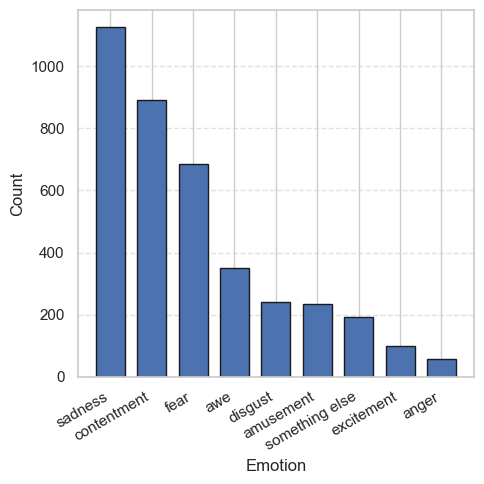

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get counts
dominant_counts = test_df['dominant_emotion'].value_counts()

plt.figure(figsize=(5, 5))
bars = plt.bar(
    dominant_counts.index,
    dominant_counts.values,
    edgecolor='k',
    width=0.7
)

plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
train_df_full['dominant_emotion'] = train_df_full['multi_hot_label'].apply(lambda x: idx_to_emotion[torch.argmax(x).item()])
# get majority class accuracy
majority_class = train_df_full['dominant_emotion'].value_counts().idxmax()
print(train_df_full['dominant_emotion'].value_counts())
# Fix the KeyError by ensuring the majority_class is correctly calculated
majority_class = train_df_full['dominant_emotion'].value_counts().idxmax()
majority_class_count = train_df_full['dominant_emotion'].value_counts()[majority_class]
print(f"Majority class: {majority_class} appears {majority_class_count / len(train_df_full) * 100:.2f}% of the time")

In [ ]:


# --- 6. Subset Selection (Random Sample of Unique Images) ---
if USE_SUBSET and SUBSET_FRACTION > 0 and SUBSET_FRACTION < 1:
    print(f"Selecting a random {SUBSET_FRACTION:.0%} subset of UNIQUE train/val images...")

    # Combine unique train and validation images
    train_val_unique_full = pd.concat([train_df_full, val_df_full], ignore_index=True)

    # Sample a fraction of the unique images randomly
    # NOTE: Stratification on multi-hot labels is complex, doing random sample for simplicity.
    subset_df = train_val_unique_full.sample(frac=SUBSET_FRACTION, random_state=RANDOM_SEED).reset_index(drop=True)
    print(f"Total unique images in subset: {len(subset_df)}")

    # Split this SUBSET back into train and validation (simple split, no stratification here)
    # Calculate the original train/(train+val) ratio based on *unique image counts*
    if (len(train_df_full) + len(val_df_full)) > 0:
       original_train_ratio = len(train_df_full) / (len(train_df_full) + len(val_df_full))
    else:
       original_train_ratio = 1.0 # Default if no val data

    if len(subset_df) < 2 or original_train_ratio >=1 or original_train_ratio <=0 :
         print("Warning: Subset too small or original ratio invalid for train/val split. Using entire subset for training.")
         train_df = subset_df
         val_df = pd.DataFrame(columns=subset_df.columns) # Empty df
    else:
        # Use train_test_split just for index splitting
        train_indices, val_indices = train_test_split(
            subset_df.index,
            train_size=original_train_ratio,
            random_state=RANDOM_SEED
            # No stratification here for simplicity
        )
        train_df = subset_df.loc[train_indices].reset_index(drop=True)
        val_df = subset_df.loc[val_indices].reset_index(drop=True)

    print(f"Unique images in subset splits: Train={len(train_df)}, Val={len(val_df)}")

else:
    print("Using full unique image sets for training and validation.")
    train_df = train_df_full
    val_df = val_df_full



In [ ]:

# --- Visualize Emotion Distribution ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

# 1. Distribution across all annotations in the original dataset
print("\nVisualizing emotion distribution in the dataset...")
plt.figure(figsize=(12, 6))
emotion_counts = df['emotion'].value_counts().sort_index()
ax = sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Emotion Distribution in All Annotations', fontsize=15)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'figures/emotion_distribution_all_{CURRENT_TIME}.png', dpi=300)
plt.show()

# 2. Distribution in multi-hot encoded unique images (counts per split)
plt.figure(figsize=(14, 8))

# Count how many images have each emotion in each split
train_emotions = train_df['multi_hot_label'].apply(lambda t: [i for i, val in enumerate(t) if val == 1])
val_emotions = val_df['multi_hot_label'].apply(lambda t: [i for i, val in enumerate(t) if val == 1])
test_emotions = test_df['multi_hot_label'].apply(lambda t: [i for i, val in enumerate(t) if val == 1])

# Flatten the lists and count
train_counts = np.zeros(num_classes)
val_counts = np.zeros(num_classes)
test_counts = np.zeros(num_classes)

for emotion_list in train_emotions:
    for emotion_idx in emotion_list:
        train_counts[emotion_idx] += 1
        
for emotion_list in val_emotions:
    for emotion_idx in emotion_list:
        val_counts[emotion_idx] += 1
        
for emotion_list in test_emotions:
    for emotion_idx in emotion_list:
        test_counts[emotion_idx] += 1

# Create a grouped bar chart
x = np.arange(len(emotions))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width, train_counts, width, label='Train')
ax.bar(x, val_counts, width, label='Validation')
ax.bar(x + width, test_counts, width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(emotions, rotation=45, ha='right')
ax.set_title('Emotion Distribution Across Dataset Splits (Unique Images)', fontsize=15)
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Count of Images with Emotion', fontsize=12)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'figures/emotion_distribution_splits_{CURRENT_TIME}.png', dpi=300)
plt.show()

# 3. Average number of emotions per image
train_emotion_counts = train_df['multi_hot_label'].apply(lambda t: t.sum().item())
val_emotion_counts = val_df['multi_hot_label'].apply(lambda t: t.sum().item())
test_emotion_counts = test_df['multi_hot_label'].apply(lambda t: t.sum().item())
print(train_emotion_counts.max(), val_emotion_counts.max(), test_emotion_counts.max())
print(range(1, int(max(train_emotion_counts.max(), val_emotion_counts.max(), test_emotion_counts.max()) + 2)))
print(range(1, int(max(train_emotion_counts.max(), val_emotion_counts.max(), test_emotion_counts.max())) + 2))
plt.figure(figsize=(10, 6))
sns.histplot(data=[train_emotion_counts, val_emotion_counts, test_emotion_counts], 
             bins=3,
             alpha=0.7, 
             label=['Train', 'Validation', 'Test'])
plt.title('Number of Emotions per Image', fontsize=15)
plt.xlabel('Number of Emotions', fontsize=12)
plt.ylabel('Count of Images', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
if SAVE_FIGS:
    # Save the figure
    plt.savefig(f'figures/emotions_per_image_{CURRENT_TIME}.png', dpi=300)
plt.show()

# 4. Co-occurrence matrix (how often emotions appear together)
# This is useful to understand which emotions frequently co-occur
co_occurrence = np.zeros((num_classes, num_classes))

# Combine all splits for co-occurrence
all_multi_hot = pd.concat([train_df, val_df, test_df])['multi_hot_label']

for multi_hot in all_multi_hot:
    # Get indices of all 1s
    indices = [i for i, val in enumerate(multi_hot) if val == 1]
    
    # Update co-occurrence matrix
    for i in indices:
        for j in indices:
            co_occurrence[i, j] += 1

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, annot=True, fmt='.0f', xticklabels=emotions, yticklabels=emotions, cmap='YlGnBu')
plt.title('Emotion Co-occurrence Matrix', fontsize=15)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'figures/emotion_cooccurrence_{CURRENT_TIME}.png', dpi=300)
plt.show()

# Print summary statistics
print("\n----- Emotion Distribution Summary -----")
print(f"Total unique images: {len(df_unique_images)}")
print(f"Average emotions per image: {np.mean([t.sum().item() for t in df_unique_images['multi_hot_label']]):.2f}")
print(f"Most common emotion: {emotions[np.argmax(emotion_counts)]}")
print(f"Least common emotion: {emotions[np.argmin(emotion_counts)]}")

# Most common co-occurring emotions
max_co_idx = np.unravel_index(co_occurrence.argmax(), co_occurrence.shape)
if max_co_idx[0] != max_co_idx[1]:  # Exclude same emotion
    print(f"Most common co-occurring emotions: {emotions[max_co_idx[0]]} and {emotions[max_co_idx[1]]}")